---
<img src="../assets/grt_logo.png" style="float: left; margin: 20px; height: 55px">

# Garton Research & Trading

_August 16, 2019_

---

## Forecasting Futures Prices with LSTMs

---

**Context:** The purpose of this study is to experiment with implementing Long Short Term Memory neural networks to predict futures prices. The data for this study consists of continuous futures contracts (generic first nearby with naive rolling method) from the Wiki Continuous Futures dataset on [Quandl](https://www.quandl.com/data/CHRIS-Wiki-Continuous-Futures). The specific markets I chose to use are based on the markets used in the original 'Turtle Traders' strategy (CITATION NEEDED).

_Author: Matthew Garton_

In [1]:
# standard data science imports
import pandas as pd
import numpy as np
import datetime

# necessary for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Import and Preprocess Data

In [2]:
# import a dataset
sugar = pd.read_csv('../data/ICE_SB1.csv', 
                    usecols=['Date','Settle'], 
                    index_col='Date', 
                    parse_dates=True)

In [3]:
sugar.head()

,Settle
Date,
1961-01-04,2.90
1961-01-05,2.91
1961-01-06,2.97
1961-01-09,3.01
1961-01-10,3.02


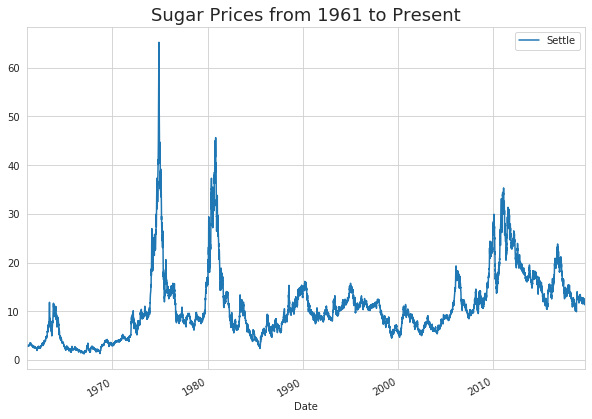

In [4]:
sugar.plot(figsize=(10,7))
plt.title('Sugar Prices from 1961 to Present', fontsize=18);

### Note on regimes and sampling

It is clear that the full history here is dominated by a few significant regimes. My expectation is that the LSTM model will be trained on a relatively short time span to predict an even shorter one, so looking at several decades of data which include some extreme events is unlikely to be successful. So I will choose a more recent subsample of the data to look at. Starting in the year 2000, in the middle of a 'boring' regime may be reasonable. I'll have to return to this later, but for now I'm satisfied with ignoring the extreme inflation of the 70's and 80's (with the knowledge that my strategy would become invalid if such a regime were to reappear).

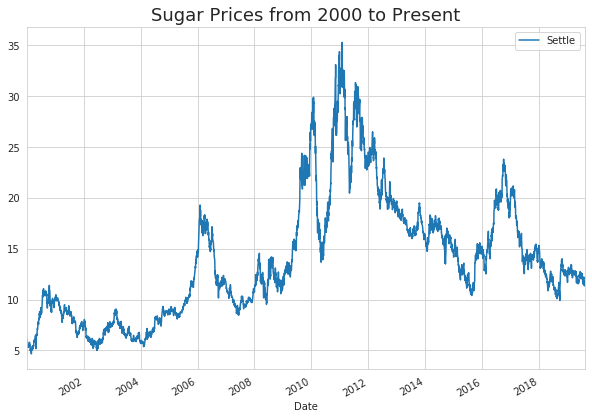

In [5]:
sugar = sugar['2000':]
sugar.plot(figsize=(10,7))
plt.title('Sugar Prices from 2000 to Present', fontsize=18);

### Difference the data until approximately stationary

/home/mattg/anaconda3/envs/quant/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


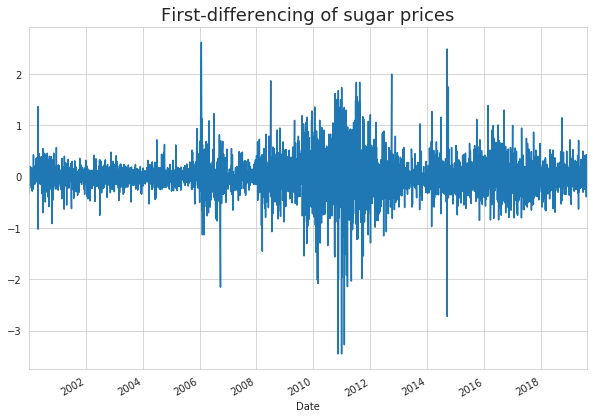

In [6]:
sugar['ds'] = sugar['Settle'].diff()
sugar['ds'].plot(figsize=(10,7))
plt.title('First-differencing of sugar prices', fontsize=18);

### Format Data for LSTM

LSTM neural networks require input in a particular shape. I'll demonstrate two methods for preparing the data: one will be a more 'hands on' approach that is more explicit but requires more steps. Then, I'll make use of the `TimeSeriesGenerator` provided by `keras`. `TimeSeriesGenerator` is a time saver, but I prefer starting out with the manual approach, as data prep for neural nets can get convoluted (no pun intended) and it helps to be forced to keep track of the state of your data at each stage. This is especially crucial in time series forecasting, which typically involves transformations on the front-end that will have to be inverted at the end (i.e. differencing for stationarity).

**Citation:** Credit to Jason Brownlee, PhD and his blog [Machine Learning Mastery](https://machinelearningmastery.com/) which was an instrumental resource for me in learning LSTM workflows. I've endeavored to write my own functions where possible, but the code snippets in his blog were a great starting point.

In [7]:
# manual approach - define all functions I'll need
def format_ts(data, lags=7):
    '''
    Returns a time series that has been formatted for a supervised learning problem
    
    Inputs:
    data - time series data as a numpy array
    
    Returns:
    df* - dataframe where each row includes columns of lagged observations
    *returns the values of this df as a numpy array
    '''
    
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lags+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.dropna(0, inplace=True)
    return df.values

def inverse_diff_transform(data, yhat, d):
    '''
    Invert differencing of data
    Inputs:
    data - time series data in original units
    yhat - predictions
    d - order of differencing
    Outputs:
    preds - predictions in the same units as original time series
    '''
    return yhat + data[-d]

def scale_data(train, test):
    '''
    MinMaxScale data before fitting LSTM
    '''
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train = train.reshape(train.shape[0], train.shape[1])
    train_sc = scaler.fit_transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_sc = scaler.transform(test)
    return scaler, train_sc, test_sc

### Data Transformation Pipeline

**Front-end:**
1. Difference the data for stationarity
2. Train-test Split
3. Scale the data --> save a copy
4. Reshape data

**Back-end:**
1. Inverse scale
2. Inverse Difference
3. Re-combine all data

In [8]:
# format the differenced ts data
s = format_ts(sugar['ds'].values, lags=7)

# train test split
train_split = int(.7*s.shape[0])
train, test = s[0:train_split], s[train_split:s.shape[0]]

# scale data
scaler, train_sc, test_sc = scale_data(train, test)

# set up X and y for training
X, y = train_sc[:, 0:-1], train_sc[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

# set up X and y for test data
Xt, yt = test_sc[:, 0:-1], test_sc[:, -1]
Xt = Xt.reshape(Xt.shape[0], 1, Xt.shape[1])

### Build and train the LSTM

In [42]:
def train_lstm(X, y, Xt, yt, epochs=1, batch_size=1):
    '''
    Train the LSTM model and validate on testing data
    Inputs:
    X - training inputs
    y - training outputs
    Xt - validation inputs
    yt - validation outputs
    epochs - number of training epochs
    Outputs:
    model - LSTM model fit to training data
    history - model history
    '''
    
    # instantiate empty dictionary for model history
    model_hist = {
        'loss': [],
        'val_loss': []
           }
    
    # reset the state of the model between each training epoch
    for i in range(epochs):
        if i < epochs-1:
            history = model.fit(X, y, 
                                epochs=1, 
                                batch_size=batch_size,
                                verbose=0, 
                                shuffle=False,
                                validation_data=(Xt, yt))
            model_hist['loss'].extend(history.history['loss'])
            model_hist['val_loss'].extend(history.history['val_loss'])
            model.reset_states()
        # return the history after the last training epoch; validate on testing data
        else:
            history = model.fit(X, y, 
                                epochs=1, 
                                batch_size=batch_size, 
                                verbose=1, 
                                shuffle=False,
                                validation_data=(Xt, yt))
            model_hist['loss'].extend(history.history['loss'])
            model_hist['val_loss'].extend(history.history['val_loss'])
            
    return model, model_hist

In [48]:
# initialize hyperparameters here
neurons = 100
batch_size = 1
epochs = 50

In [49]:
# define model architecture and build
model = Sequential()
model.add(LSTM(neurons, activation='relu', batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [50]:
# train the model
model, model_hist = train_lstm(X, y, Xt, yt, batch_size=batch_size, epochs=epochs)

Train on 3265 samples, validate on 1400 samples
Epoch 1/1
3265/3265 [==============================] - 9s 3ms/step - loss: 0.0147 - val_loss: 0.0121


### Analyze results of model

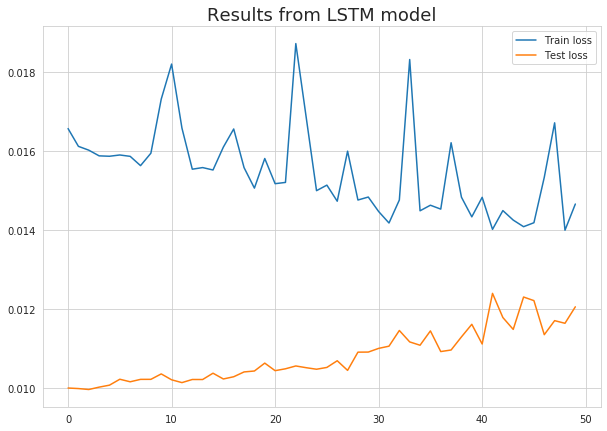

In [52]:
plt.figure(figsize=(10,7))
plt.plot(model_hist['loss'], label='Train loss')
plt.plot(model_hist['val_loss'], label='Test loss')
plt.title('Results from LSTM model', fontsize=18)
plt.legend();

### Forecasting with the model

**Note:** to facilitate comparing predictions to actual data, I will need to reverse the transformations that I originally made to my data, so that I can ultimately plot 'prices' and 'predicted prices.'

In [54]:
yhat = model.predict(Xt, batch_size=1)

In [ ]:
# use model to predict
test = TimeseriesGenerator(train, train, length=lags, batch_size=32)
yhat = model.predict_generator(test)
model.evaluate_generator(test)